In [19]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

'''
Raw Dataset을 로딩하는 과정 
+ 전체 series 데이터로부터 필요한 부분만 segmentation하는 부분 포함 
+ 1d를 2d로 reshape하는 과정 포함 
- scale up 과정 미포함
'''

'''
Path Settings
'''
CONFIGURATION_FILE_PATH = "./data/train/data_config.csv"
DATASET_PATH = "./data/train/"


'''
Figure Settings
'''
pd.set_option('display.width', 200) # for display width


'''
1. Read Configurration File (only xls)
'''
data_config = pd.read_csv(CONFIGURATION_FILE_PATH, header=0, index_col=0)
print("Configuration Dataframe dimension: ", data_config.shape)

'''
2. Read all FSR matrix data and Seat sensor data
'''
fsr_dataframe = {}
seat_dataframe = {}

for idx in data_config.index:
    fsr_filepath = DATASET_PATH+data_config.loc[idx, "fsr_matrix_1d_datafile"] # set FSR matrix data filepath
    seat_filepath = DATASET_PATH+data_config.loc[idx, "seat_datafile"] # set Seat data filepath
    print(idx, ") read data files : ", fsr_filepath, ",", seat_filepath)

    fsr_dataframe[idx] = pd.read_csv(fsr_filepath, header=0, index_col=False).iloc[:,0:162] # read FSR matrix data file
    seat_dataframe[idx] = pd.read_csv(seat_filepath, header=0, index_col=False) # read Seat data file

    # clear unnecessary columns
    del seat_dataframe[idx]['Measurement time'] # remove unnecessary column
    del fsr_dataframe[idx]['Measurement Time (sec)'] # remove unnecessary column



'''
3. Preproceess : Data Segmentation by mtime
   - @brief     FSR matrix data and Seat data should be segmented by mtime
   - @output    segmented dataframes
'''

# output dict.
fsr_dataframe_standard_segment = {}
fsr_dataframe_relax_segment = {}
seat_loadcell_dataframe_standard_segment = {}
seat_loadcell_dataframe_relax_segment = {}

for idx in data_config.index:
    mtime = data_config.loc[idx, ['standard_s_mtime', "standard_e_mtime", "relax_s_mtime", "relax_e_mtime"]]

    # seat loadcell segmentation
    seat_loadcell_dataframe_standard_segment[idx] = seat_dataframe[idx][(seat_dataframe[idx]['mtime']>=mtime.standard_s_mtime) & (seat_dataframe[idx]['mtime']<=mtime.standard_e_mtime)]
    seat_loadcell_dataframe_relax_segment[idx] = seat_dataframe[idx][(seat_dataframe[idx]['mtime']>=mtime.relax_s_mtime) & (seat_dataframe[idx]['mtime']<=mtime.relax_e_mtime)]

    # fsr matrix segmentation
    fsr_dataframe_standard_segment[idx] = fsr_dataframe[idx][(fsr_dataframe[idx]['mtime']>=mtime.standard_s_mtime) & (fsr_dataframe[idx]['mtime']<=mtime.standard_e_mtime)]
    fsr_dataframe_relax_segment[idx] = fsr_dataframe[idx][(fsr_dataframe[idx]['mtime']>=mtime.relax_s_mtime) & (fsr_dataframe[idx]['mtime']<=mtime.relax_e_mtime)]

    print("FSR Segments@Standard size : ", len(fsr_dataframe_standard_segment[idx]), ", FSR Segments@Relax size : ", len(fsr_dataframe_relax_segment[idx]))
    print("Seat Segments@Standard size : ", len(seat_loadcell_dataframe_standard_segment[idx]), ", Seat Segments@Relax size : ", len(seat_loadcell_dataframe_relax_segment[idx]))



Configuration Dataframe dimension:  (49, 12)
1 ) read data files :  ./data/train/20210303T160024-1dm.csv , ./data/train/data_01m.csv
2 ) read data files :  ./data/train/20210310T104529-1dm.csv , ./data/train/data_02m.csv
3 ) read data files :  ./data/train/20210310T110616-1dm.csv , ./data/train/data_03m.csv
4 ) read data files :  ./data/train/20210318T170103-1dm.csv , ./data/train/data_04m.csv
5 ) read data files :  ./data/train/20210310T153307-1dm.csv , ./data/train/data_05m.csv
6 ) read data files :  ./data/train/20210310T154900-1dm.csv , ./data/train/data_06m.csv
7 ) read data files :  ./data/train/20210311T131751-1dm.csv , ./data/train/data_07m.csv
8 ) read data files :  ./data/train/20210311T134516-1dm.csv , ./data/train/data_08m.csv
9 ) read data files :  ./data/train/20210311T150952-1dm.csv , ./data/train/data_09m.csv
10 ) read data files :  ./data/train/20210311T153746-1dm.csv , ./data/train/data_10m.csv
11 ) read data files :  ./data/train/20210311T154809-1dm.csv , ./data/trai

In [20]:
'''
데이터를 catrom으로 interpolation(dynamic scale)하고
좌우 데이터가 상대적으로 다른 스케일로 측정되는 문제에서
잘 나오는 쪽만 crop하여 처리하도록 함.
이때 scale up의 min max는 0~255의 절대범위가 아닌, 각 series마다 local min/max를 기준으로 한다.
+ only standard mode
'''
import os
import os.path
import gc
from skimage import io, color

DYNAMIC_SCALEUP = True

CASE_PATH = "./catmul_static"

crop_standard_interpolated_path = {}

if DYNAMIC_SCALEUP==True:
    try:
        #os.mkdir("./high") # create diretory
        os.mkdir(CASE_PATH) # create diretory
        # os.mkdir("./none") # create diretory
    except FileExistsError:
        pass

    for idx in data_config.index:
        fsr_standard_segment_1d = fsr_dataframe_standard_segment[idx].iloc[:,1:161]
        fsr_standard_segment_2d = fsr_standard_segment_1d.values.reshape(-1, 16, 10) # reshape

        try:
            # os.mkdir("./high/{}".format(idx)) # create diretory for each id
            os.mkdir("{}/{}".format(CASE_PATH, idx)) # create diretory for each id
            # os.mkdir("./none/{}".format(idx)) # create diretory for each id
        except FileExistsError:
            pass


        standard_fsr_crop_file_list = []

        for ridx in range(fsr_standard_segment_2d.shape[0]):
            # result_image_filepath = "./high/{}/standard_{}.jpg".format(idx, ridx)
            # result_crop_image_filepath = "./high/{}/standard_crop_{}.jpg".format(idx, ridx)
            result_image_filepath = "{}/{}/standard_{}.jpg".format(CASE_PATH, idx, ridx)
            result_crop_image_filepath = "{}/{}/standard_crop_{}.jpg".format(CASE_PATH, idx, ridx)
            # result_image_filepath = "./none/{}/standard_{}.jpg".format(idx, ridx)
            # result_crop_image_filepath = "./none/{}/standard_crop_{}.jpg".format(idx, ridx)

            # data interpolation
            if os.path.isfile(result_image_filepath)==False:
                fig = plt.figure()
                plt.axis('off')
                #plt.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', cmap='Greys_r') # dynamic
                plt.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='Greys_r') # statuc
                #plt.imshow(fsr_standard_segment_2d[ridx], interpolation='none', cmap='Greys_r')
                plt.savefig(result_image_filepath, bbox_inches='tight', pad_inches=0)
                plt.close()
            else:
                pass

            # crop active region
            if os.path.isfile(result_crop_image_filepath)==False:
                image = io.imread(result_image_filepath)
                grayscale = color.rgb2gray(image)
                crop = grayscale[0:grayscale.shape[0],int(grayscale.shape[1]/2):grayscale.shape[1]]
                io.imsave(result_crop_image_filepath, crop)
                print("(standard) saved output crop images for id {}, {}".format(idx, ridx))
            else:
                pass

            standard_fsr_crop_file_list.append(result_crop_image_filepath)
            
        crop_standard_interpolated_path[idx] = pd.DataFrame(standard_fsr_crop_file_list, columns=['path'])
        print(crop_standard_interpolated_path[idx])

print("done")

tandard_crop_2.jpg
3      ./catmul_static/15/standard_crop_3.jpg
4      ./catmul_static/15/standard_crop_4.jpg
..                                        ...
126  ./catmul_static/15/standard_crop_126.jpg
127  ./catmul_static/15/standard_crop_127.jpg
128  ./catmul_static/15/standard_crop_128.jpg
129  ./catmul_static/15/standard_crop_129.jpg
130  ./catmul_static/15/standard_crop_130.jpg

[131 rows x 1 columns]
                                         path
0      ./catmul_static/16/standard_crop_0.jpg
1      ./catmul_static/16/standard_crop_1.jpg
2      ./catmul_static/16/standard_crop_2.jpg
3      ./catmul_static/16/standard_crop_3.jpg
4      ./catmul_static/16/standard_crop_4.jpg
..                                        ...
120  ./catmul_static/16/standard_crop_120.jpg
121  ./catmul_static/16/standard_crop_121.jpg
122  ./catmul_static/16/standard_crop_122.jpg
123  ./catmul_static/16/standard_crop_123.jpg
124  ./catmul_static/16/standard_crop_124.jpg

[125 rows x 1 columns]
             

In [21]:

'''
Feature Engineering : save to feature image
+ 1D max pooling (input data : (batch, steps, features)))
'''

from skimage import io, color
import tensorflow as tf
from tensorflow.keras.layers import MaxPool1D, GlobalMaxPooling1D

SAVE_FEATURE_IMAGE = True

try:
    os.mkdir("{}/feature".format(CASE_PATH)) # create diretory
except FileExistsError:
    pass

featureset_container = {}
for idx in data_config.index:
    feature_set = np.array([], dtype=np.int64).reshape(0, 217)#empty(217)

    for f in crop_standard_interpolated_path[idx]["path"]:
        image = io.imread(f)
        grayscale = color.rgb2gray(image) # (217, 68)
        tensor = tf.reshape(grayscale, [grayscale.shape[0], grayscale.shape[1], 1]) # (217, 68, 1)
        feature = tf.keras.layers.GlobalMaxPooling1D()(tensor).numpy() #(217,1)
        feature_1d = feature.reshape(feature.shape[0]) #(217,)
        feature_set = np.vstack([feature_set, feature_1d])

    if SAVE_FEATURE_IMAGE == True:
        io.imsave("{}/feature/standart_feature_{}.png".format(CASE_PATH, idx), feature_set.transpose())
    featureset_container[idx] = feature_set
    print("created featureset :", idx)

print("done")



<ipython-input-21-a5cd4181fe92>:23: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  grayscale = color.rgb2gray(image) # (217, 68)
<ipython-input-21-a5cd4181fe92>:30: UserWarning: ./catmul_static/feature/standart_feature_1.png is a low contrast image
  io.imsave("{}/feature/standart_feature_{}.png".format(CASE_PATH, idx), feature_set.transpose())
Lossy conversion from int64 to uint8. Range [0, 99]. Convert image to uint8 prior to saving to suppress this warning.
created featureset : 1
<ipython-input-21-a5cd4181fe92>:30: UserWarning: ./catmul_static/feature/standart_feature_2.png is a low contrast image
  io.imsave("{}/feature/standart_feature_{}.png".format(CASE_PATH, idx), feature_set.transpose())
Lossy conversion from int64 to uint8. Range [0, 73]. Convert image to uin

In [ ]:
'''
SVM model training & predict with full dimensional data
'''


'''
svm with positive class
'''
from sklearn import svm
from sklearn.datasets._samples_generator import make_blobs
from tensorflow.keras.layers import MaxPool1D, GlobalMaxPooling1D

feautre_length = 115 #115 dimensional dataset
feature_set = np.array([], dtype=np.int64).reshape(0, feautre_length)

print("featureset shape :",feature_set.shape)

for idx in data_config.index:
    tensor = tf.reshape(featureset_container[idx], [featureset_container[idx].shape[0], featureset_container[idx].shape[1], 1]) # (1??, 217, 1)
    # print(tensor.shape)
    feature = tf.keras.layers.GlobalMaxPooling1D()(tensor).numpy() #(1??,1)
    # print(feature.shape)
    feature_1d = feature.reshape(feature.shape[0]) #(1??,)
    # print(feature_1d.shape)
    feature_set = np.vstack([feature_set, feature_1d[0:feautre_length]])

print("pclass shape :", pclass.shape)
print("feature length:", feautre_length)
print("feature_set:", feature_set.shape)

# plt.figure()
# plt.plot(feature_set)
# plt.show()


# random selection
import random
shuffled_index = np.arange(feature_set.shape[0])
random.shuffle(shuffled_index)
print("shuffled", shuffled_index)

pclass = shuffled_index[0:49] # first 5 index select from shuffled_index
nclass = shuffled_index[5:]


X = feature_set[pclass[:,None]].reshape(pclass.shape[0], feautre_length)
y = pclass

print("pclass :", pclass)
model = svm.SVC(kernel='linear')
model.fit(X,y)


print(model.predict([X[0]]))
print(model.predict([X[1]]))
print(model.predict([X[2]]))
print(model.predict([X[3]]))
print(model.predict([X[4]]))
print("done")


In [ ]:
'''
SVM model training & predict with n-dimensional data
'''


'''
svm with positive class
'''
from sklearn import svm
from sklearn.datasets._samples_generator import make_blobs
from tensorflow.keras.layers import MaxPool1D, GlobalMaxPooling1D

feautre_length = 10 # n-dimension
feature_pt = random.choice(np.arange(100)) # random point to segment
feature_set = np.array([], dtype=np.int64).reshape(0, feautre_length)
# print("featureset shape :",feature_set.shape)

for idx in data_config.index:
    tensor = tf.reshape(featureset_container[idx], [featureset_container[idx].shape[0], featureset_container[idx].shape[1], 1]) # (1??, 217, 1)
    # print(tensor.shape)
    feature = tf.keras.layers.GlobalMaxPooling1D()(tensor).numpy() #(1??,1)
    # print(feature.shape)
    feature_1d = feature.reshape(feature.shape[0]) #(1??,)
    # print("feature 1d :",feature_1d.shape)

    feature_set = np.vstack([feature_set, feature_1d[feature_pt:feautre_length+feature_pt]])

# print("feature length:", feautre_length)
# print("feature_set:", feature_set.shape)


# # random selection
import random
shuffled_index = np.arange(feature_set.shape[0])
random.shuffle(shuffled_index)
print("shuffled", shuffled_index)

pclass = shuffled_index[0:feature_set.shape[0]] # first 5 index select from shuffled_index
# print("pclass shape :", pclass.shape)

X = feature_set[pclass[:,None]].reshape(pclass.shape[0], feautre_length)
y = pclass

print("pclass :", pclass)
model = svm.SVC(kernel='linear')
model.fit(X,y)


print(model.predict([X[0]]))
print(model.predict([X[1]]))
print(model.predict([X[2]]))
print(model.predict([X[3]]))
print(model.predict([X[4]]))


In [22]:
'''
SVM Model training & predict with n-dimentional augmented data
'''


'''
svm with positive class
'''
from sklearn import svm
from sklearn.datasets._samples_generator import make_blobs
from tensorflow.keras.layers import MaxPool1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
import random
from sklearn import metrics

feautre_length = 5 # n-dimensional dataset
feature_pt = random.choice(np.arange(100)) # random point to segment
number_of_samples = 999 # 1 is raw feature, 99 is augmented feature

augmented_data_dict = {}
for idx in data_config.index:
    feature_set = np.array([], dtype=np.int64).reshape(0, feautre_length)

    tensor = tf.reshape(featureset_container[idx], [featureset_container[idx].shape[0], featureset_container[idx].shape[1], 1]) # (1??, 217, 1)
    # print(tensor.shape)
    feature = tf.keras.layers.GlobalMaxPooling1D()(tensor).numpy() #(1??,1)
    # print(feature.shape)
    feature_1d = feature.reshape(feature.shape[0]) #(1??,)
    # print(feature_1d.shape)
    feature_set = np.vstack([feature_set, feature_1d[feature_pt:feautre_length+feature_pt]])

    # data augmentation
    mu, sigma = 0, 3
    for aug in range(number_of_samples):
        aug_1d = np.random.normal(mu, sigma, feature_1d.shape[0])
        feature_1d = feature_1d + aug_1d
        np.clip(feature_1d, 0, None) # lower bound
        # save featureset
        feature_set = np.vstack([feature_set, feature_1d[0:feautre_length]])

    augmented_data_dict[idx] = feature_set
    # print("augmented set:", augmented_data_container[idx].shape)

print("augmented :", len(augmented_data_dict))

# print("feature length:", feautre_length)
# print("feature_set:", feature_set.shape)

# random selection for testing
shuffled_index = np.array(list(data_config.index))
random.shuffle(shuffled_index)

pclass = shuffled_index[0:5] # first 5 index select from shuffled_index
print("pclass :", pclass)


# data split

Xcon_train = np.array([], dtype=np.int64).reshape(0, feautre_length)
Xcon_test = np.array([], dtype=np.int64).reshape(0, feautre_length)
ycon_train = np.array([], dtype=np.int64)
ycon_test = np.array([], dtype=np.int64)
for pc in pclass:
    X = augmented_data_dict[pc]
    y = np.full(X.shape[0], pc)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)  
    Xcon_train = np.vstack([Xcon_train, X_train])
    ycon_train = np.hstack([ycon_train, y_train])
    Xcon_test = np.vstack([Xcon_test, X_test])
    ycon_test = np.hstack([ycon_test, y_test])


# print("pclass :", pclass)
model = svm.SVC(kernel='linear', C=1, probability=True)
model.fit(Xcon_train,ycon_train)
print("model trained")

# testing
ypredictions = model.predict(Xcon_test)
print("Accuracy score: ", metrics.accuracy_score(ycon_test, ypredictions)*100)

# roc = metrics.roc_curve(model.predict_proba(Xcon_train), ycon_train)
# metrics.plot_roc_curve(model, Xcon_test, ycon_test)
# plt.show()


augmented : 49
pclass : [17 30 15 27 19]
model trained
Accuracy score:  80.9090909090909


In [63]:
'''
SVM Model training & predict with n-dimentional augmented data
# testing
'''


'''
svm with positive class
'''
from sklearn import svm
from sklearn.datasets._samples_generator import make_blobs
from tensorflow.keras.layers import MaxPool1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
import random
from sklearn import metrics

feautre_length = 20 # n-dimensional dataset
feature_pt = random.choice(np.arange(115-feautre_length)) # random point to segment
number_of_samples = 299 # 1 is raw feature, 99 is augmented feature

augmented_data_dict = {}
for idx in data_config.index:
    feature_set = np.array([], dtype=np.int64).reshape(0, feautre_length)

    tensor = tf.reshape(featureset_container[idx], [featureset_container[idx].shape[0], featureset_container[idx].shape[1], 1]) # (1??, 217, 1)
    # print("tensor shape:", tensor.shape)
    feature = tf.keras.layers.GlobalMaxPooling1D()(tensor).numpy() #(1??,1)
    # print("feature shape:", feature.shape)
    feature_1d = feature.reshape(feature.shape[0]) #(1??,)
    # print("feature 1d shape:", feature_1d.shape)
    feature_set = np.vstack([feature_set, feature_1d[feature_pt:feautre_length+feature_pt]])

    # data augmentation
    mu, sigma = 0, 1
    for aug in range(number_of_samples):
        aug_1d = np.random.normal(mu, sigma, feature_1d.shape[0])
        feature_1d = feature_1d + aug_1d
        np.clip(feature_1d, 0, None) # lower bound
        # save featureset
        feature_set = np.vstack([feature_set, feature_1d[0:feautre_length]])

    augmented_data_dict[idx] = feature_set
    # print("augmented set:", augmented_data_container[idx].shape)

print("augmented :", len(augmented_data_dict))

# print("feature length:", feautre_length)
# print("feature_set:", feature_set.shape)

# random selection for testing
shuffled_index = np.array(list(data_config.index))
random.shuffle(shuffled_index)

pclass = shuffled_index[0:5] # first 5 index select from shuffled_index
print("pclass :", pclass)

# data split
Xcon_train = np.array([], dtype=np.int64).reshape(0, feautre_length)
Xcon_test = np.array([], dtype=np.int64).reshape(0, feautre_length)
ycon_train = np.array([], dtype=np.int64)
ycon_test = np.array([], dtype=np.int64)

for pc in data_config.index:
    X = augmented_data_dict[pc]
    if pc in pclass:
        y = np.full(X.shape[0], pc)
    else:
        y = np.full(X.shape[0], 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)      
    Xcon_train = np.vstack([Xcon_train, X_train])
    ycon_train = np.hstack([ycon_train, y_train])
    Xcon_test = np.vstack([Xcon_test, X_test])
    ycon_test = np.hstack([ycon_test, y_test])


# for pc in pclass:
#     X = augmented_data_dict[pc]
#     y = np.full(X.shape[0], pc)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)  
#     Xcon_train = np.vstack([Xcon_train, X_train])
#     ycon_train = np.hstack([ycon_train, y_train])
#     Xcon_test = np.vstack([Xcon_test, X_test])
#     ycon_test = np.hstack([ycon_test, y_test])

print("x:", Xcon_train.shape)
print("y:", ycon_train)

# print("pclass :", pclass)
model = svm.SVC(kernel='linear', C=1, probability=True, max_iter=-1, verbose=2)
model.fit(Xcon_train,ycon_train)
print("model trained")

# testing
ypredictions = model.predict(Xcon_test)
print("Accuracy score: ", metrics.accuracy_score(ycon_test, ypredictions)*100)
print("Balanced score : ", metrics.balanced_accuracy_score(ycon_test, ypredictions)*100)

# roc = metrics.roc_curve(model.predict_proba(Xcon_train), ycon_train)
# metrics.plot_roc_curve(model, Xcon_test, ycon_test)
# plt.show()




augmented : 49
pclass : [26  3 24 43 11]
x: (9849, 20)
y: [0 0 0 ... 0 0 0]
[LibSVM]model trained
Accuracy score:  99.11358482787054
Balanced score :  92.92546678910315


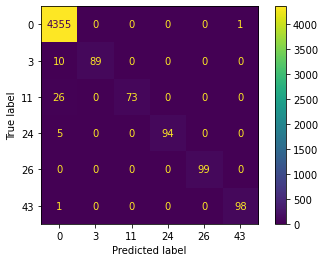

In [64]:

# precision
from sklearn.metrics import precision_score
precision_score(ycon_test, ypredictions, average=None)

# confusion metrix
metrics.confusion_matrix(ycon_test, ypredictions, normalize='all')
metrics.plot_confusion_matrix(model, Xcon_test, ycon_test)

In [62]:
'''
ROC Curve for multiclass
'''
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: name 'n_classes' is not defined